<a href="https://colab.research.google.com/github/probabll/mixed-rv-vae/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

On Colab, you will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [2]:
import torch
torch.__version__

'1.8.1+cu102'

In [3]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
from collections import namedtuple, OrderedDict, defaultdict
from tqdm.auto import tqdm
from itertools import chain
from tabulate import tabulate

In [5]:
from components import GenerativeModel, InferenceModel, VAE
from data import load_mnist
from main import load_cfg, make_args, make_state, get_batcher, validate

In [6]:
from analysis import compare_marginals, compare_samples

# Load model and data

* Load hyperparameters
* Load model state
* Load MNIST data

In [7]:
#directory = 'neurips-mixed-rv/mixed-vae/test-new-sharing/breezy-fog-49/'
#directory = 'neurips-mixed-rv/submission/deft-tree-32'
directory = 'neurips-mixed-rv/submission/icy-sponge-36'
args = make_args(
    load_cfg(
        f"{directory}/cfg.json", 
        # use this to specify a decide for analysis
        device='cuda:0',
        # use this to change paths if you need
        data_dir='./tmp',
        # you don't really need to change the output_dir
    )
)
args

Setting wandb to default False
Setting wandb_watch to default False
Overriding device to user choice cuda:0
Overriding data_dir to user choice ./tmp


Config(seed=12, batch_size=100, data_dir='./tmp', height=28, width=28, output_dir='neurips-mixed-rv/submission/icy-sponge-36', device='cuda:0', y_dim=10, prior_f='gibbs-max-ent 0', prior_y='dirichlet 1.0', z_dim=0, hidden_dec_size=500, posterior_f='gibbs -10 10', posterior_y='dirichlet 1e-3 1e3', shared_concentrations=True, mean_field=True, hidden_enc_size=500, epochs=500, num_samples=100, gen_opt='adam', gen_lr=0.0005, gen_l2=0.0, gen_p_drop=0.0, inf_opt='adam', inf_lr=0.0005, inf_l2=1e-06, inf_p_drop=0.1, grad_clip=1.0, use_self_critic=1, use_reward_standardisation=0, project='neurips21-submission', cfg='cfg/mixed-vae.json', prior_z='gaussian 0.0 1.0', posterior_z='gaussian', share_fy_net=1, training_samples=1, load_ckpt=None, reset_opt=False, exact_marginal=False, tqdm=False, wandb=False, wandb_watch=False)

In [8]:
state = make_state(
    args, 
    device=args.device, 
    # change this to .best if you want the best ckpt (rather than the last)
    ckpt_path=f"{directory}/ckpt.best"
    #ckpt_path=f"{directory}/training.ckpt"
)

In [9]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to=args.data_dir, 
    height=args.height, 
    width=args.width
)

In [10]:
val_metrics = validate(state.vae, get_batcher(valid_loader, args), 10)
print(f'Saved ckpt - Validation: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

Saved ckpt - Validation: nll=111.46 bpd=16.08


In [11]:
test_metrics = validate(state.vae, get_batcher(test_loader, args), 100, compute_DR=True)
print(f'Saved ckpt - Test: nll={test_metrics[0]:.2f} bpd={test_metrics[1]:.2f}')

Saved ckpt - Test: nll=110.93 bpd=16.00


In [12]:
rows = [('IS-NLL', test_metrics[0], None), ('IS-BPD', test_metrics[1], None)]
for k, v in test_metrics[2].items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric          mean       std
--------  ----------  --------
IS-NLL     110.925
IS-BPD      16.0031
ELBO      -113.897    38.781
D           95.7913   35.6101
R           18.1059   11.0476
R_F          9.5111    2.01847
R_Y          8.59476  10.3687


# Training Curves

In [13]:
np_stats_tr = {k: np.array(v) for k, v in state.stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in state.stats_val.items()}

In [14]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

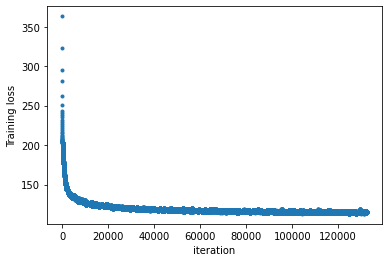

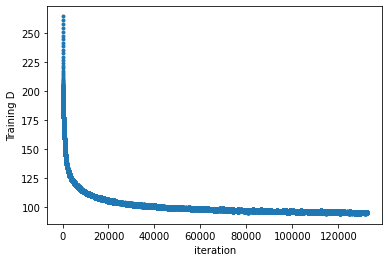

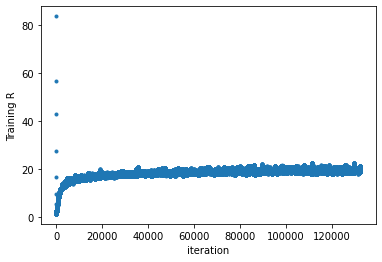

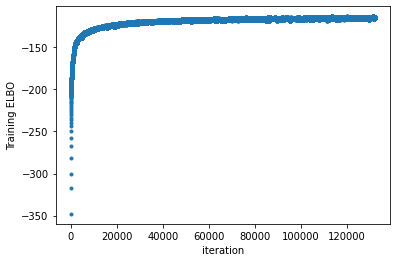

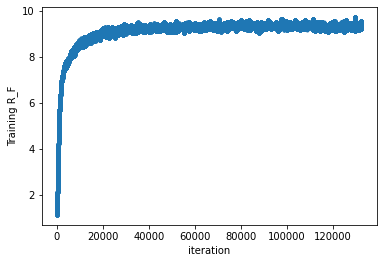

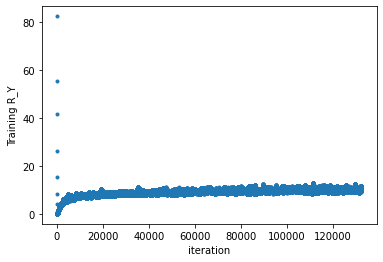

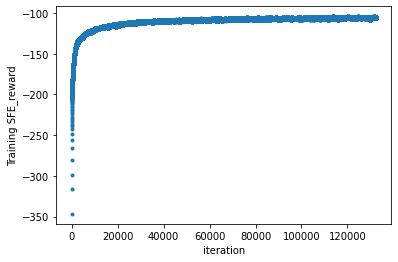

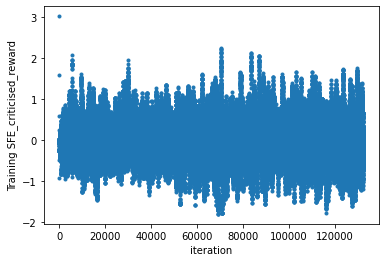

In [15]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

# Validation Curves

In [16]:
print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric          mean         min
--------  ----------  ----------
val_nll    111.353     110.748
val_bpd     16.0648     15.9775
val_ELBO  -114.135    -115.275
val_D       96.5053     95.3547
val_R       17.6297     16.7373
val_R_F      9.29046     8.98413
val_R_Y      8.33924     7.75313


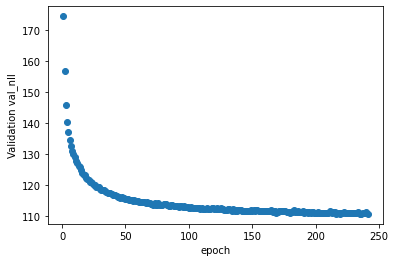

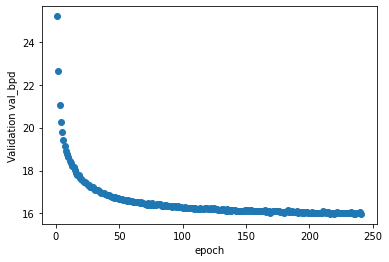

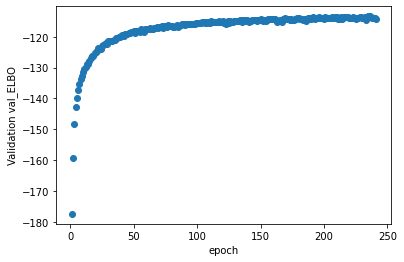

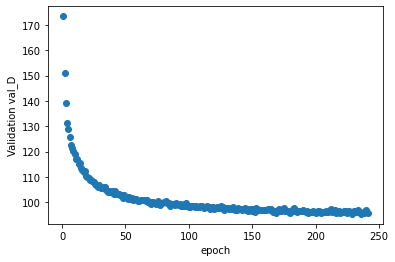

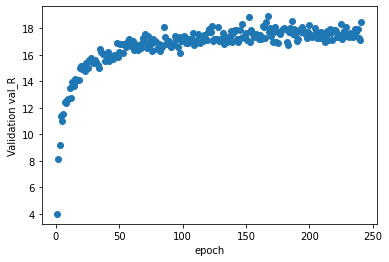

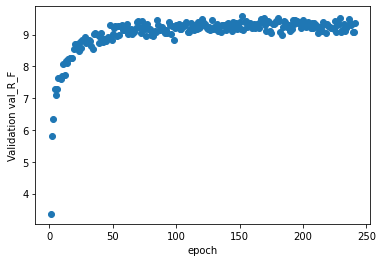

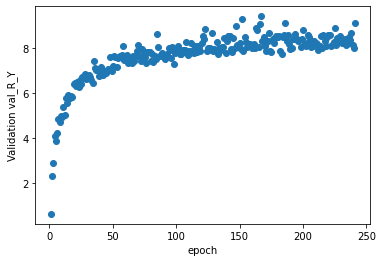

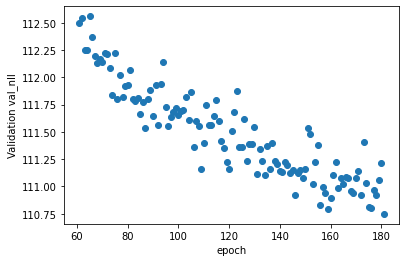

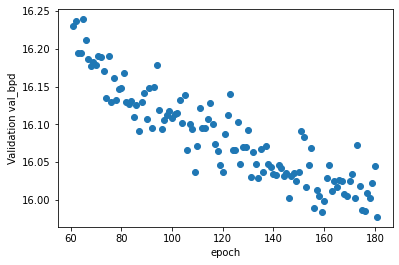

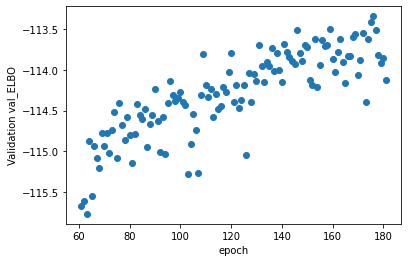

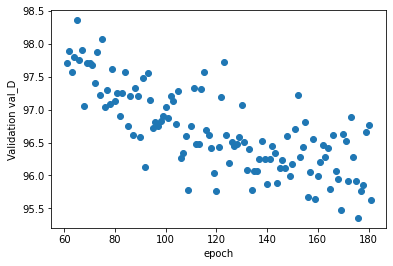

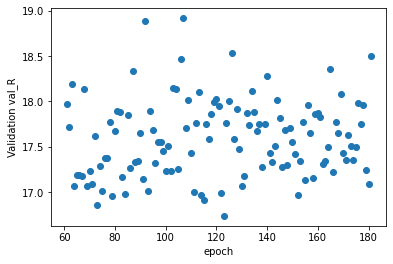

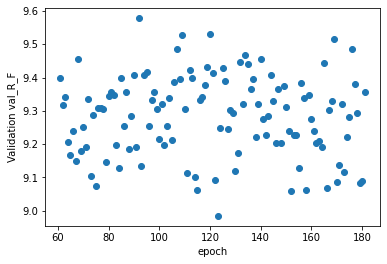

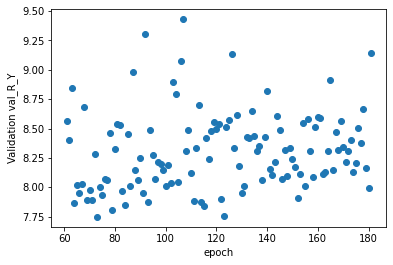

In [17]:
for k, v in np_stats_val.items():
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()
for k, v in np_stats_val.items():
    v = v[v.size//2:]
    plt.plot(np.arange(1 + v.size//2, v.size + 1 + v.size//2), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()    

In [18]:
val_nll, val_bpd, val_DR = validate(
    state.vae, get_batcher(valid_loader, args), args.num_samples, compute_DR=True)

In [19]:
rows = [('IS-NLL', val_nll, None), ('IS-BPD', val_bpd, None)]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric          mean       std
--------  ----------  --------
IS-NLL     110.887
IS-BPD      15.9976
ELBO      -113.687    38.5475
D           95.8123   33.6518
R           17.8743   14.9272
R_F          9.34944   1.99733
R_Y          8.52486  14.4023


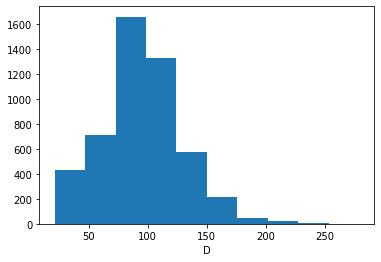

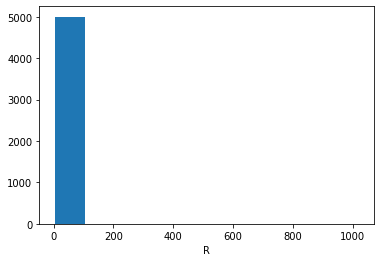

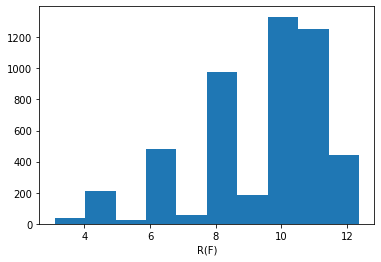

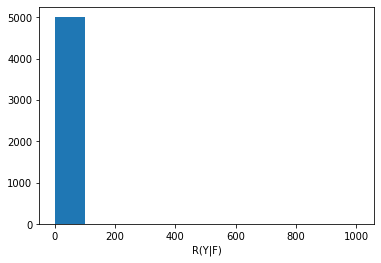

In [20]:
_ = plt.hist(val_DR['D'])
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'])
_ = plt.xlabel('R')
plt.show()

if state.vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'])
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if state.vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'])
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y'])
    _ = plt.xlabel('R(Y|F)')
    plt.show()

# Analysis

## KL

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


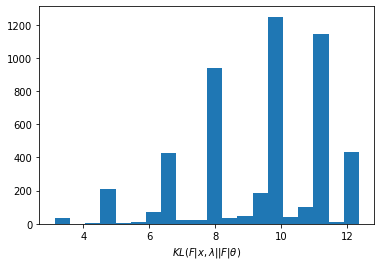

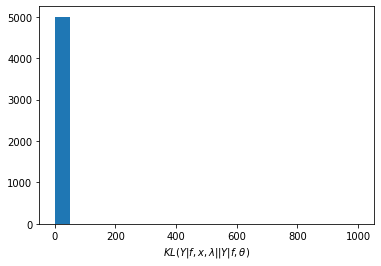

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


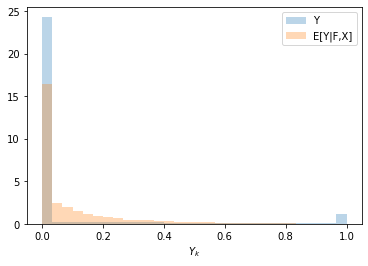

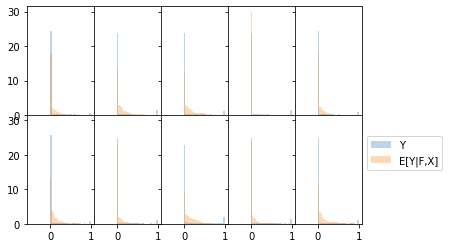

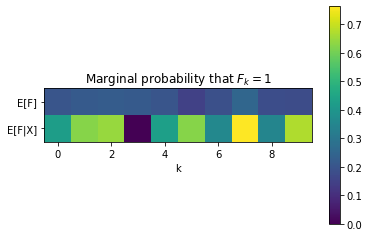

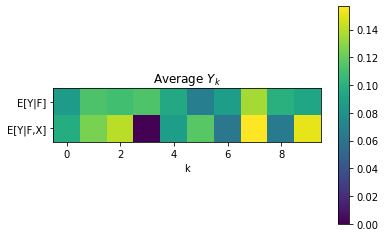

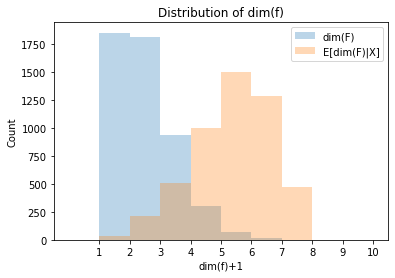

In [21]:
compare_marginals(state.vae, get_batcher(valid_loader, args), args, cols=5, num_samples=10)

## Posterior and Prior Samples

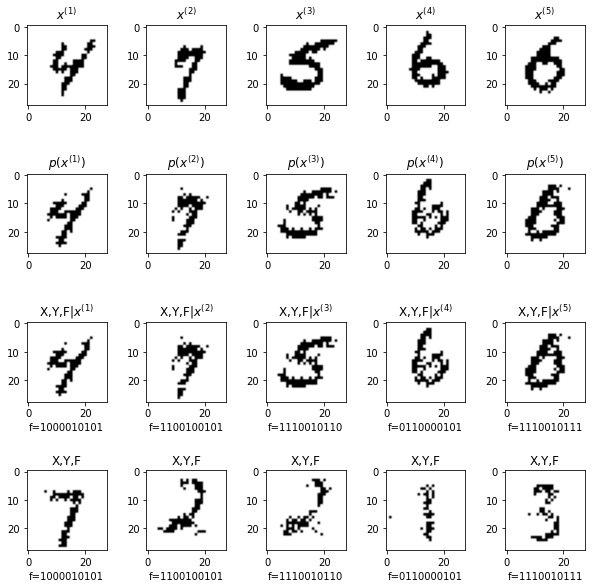

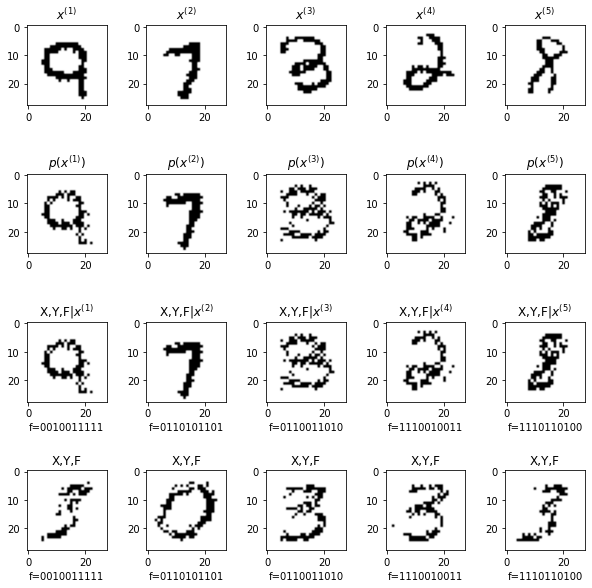

In [22]:
compare_samples(state.vae, get_batcher(valid_loader, args), args, N=5, num_figs=2, num_samples=10)

## TSNE

In [23]:
from analysis import samples_per_digit

In [24]:
f, y, z, x, marginal_f, scores, concs = samples_per_digit(
    state.vae, get_batcher(valid_loader, args, onehot=False), 
    args, return_marginal=args.y_dim > 0)

In [25]:
f.shape, f.mean(1).shape, z.shape, z.mean(1).shape, x.shape, x.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 0), (10, 0), (10, 458, 784), (10, 784))

In [26]:
marginal_f.shape, marginal_f.mean(1).shape, scores.shape, scores.mean(1).shape, concs.shape, concs.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 10), (10, 10), (10, 458, 10), (10, 10))

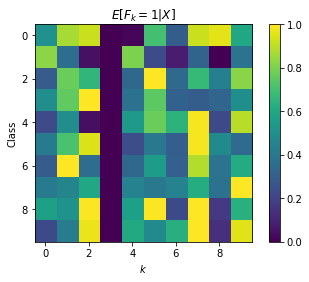

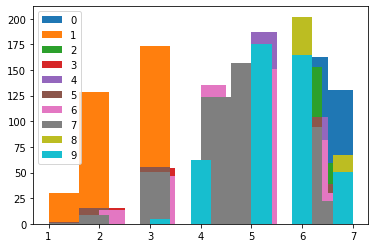

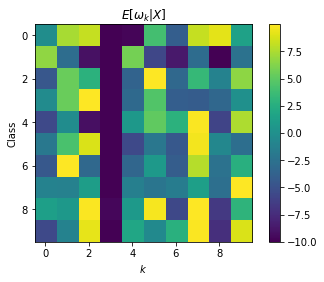

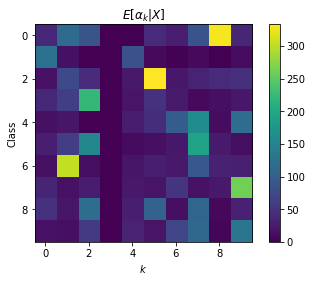

In [27]:
if state.vae.p.y_dim:
    _ = plt.imshow(f.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[F_k = 1|X]$')
    _ = plt.colorbar()
    plt.show()
    
#     _ = plt.imshow(f.sum(-1).mean(1, keepdims=True))
#     _ = plt.ylabel('Class')
#     #_ = plt.xlabel(r'$\max_k$')
#     _ = plt.xticks([], [])
#     _ = plt.title(r'mean argmax')
#     _ = plt.colorbar()
#     plt.show()
    
    for k in range(10):
        _ = plt.hist(f[k].sum(-1), label=f'{k}')
    _ = plt.legend()
    plt.show()
    
    _ = plt.imshow(scores.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\omega_k|X]$')
    _ = plt.colorbar()
    plt.show()
    
    _ = plt.imshow(concs.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\alpha_k|X]$')
    _ = plt.colorbar()
    plt.show()

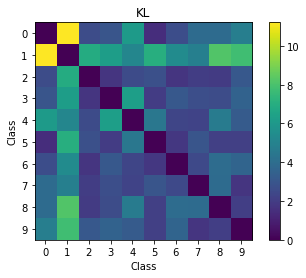

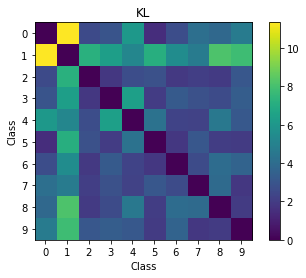

In [28]:
from itertools import product

if state.vae.p.y_dim:
    mc_marginal_f = f.mean(1)
    Fs = [td.Independent(td.Bernoulli(probs=(torch.tensor(mc_marginal_f[c])*0.99 + 1e-4)), 1) for c in range(10)]
    JS_F = np.array([[(0.5*td.kl_divergence(Fs[c], Fs[c_])+0.5*td.kl_divergence(Fs[c_], Fs[c])).numpy() for c_ in range(10)] for c in range(10)])
    #KL_F = np.array([[td.kl_divergence(Fs[c], Fs[c_]).numpy() for c_ in range(10)] for c in range(10)])
    _ = plt.imshow(JS_F)
    _ = plt.ylabel('Class')
    _ = plt.yticks(np.arange(10), np.arange(10))
    _ = plt.xlabel('Class')
    _ = plt.xticks(np.arange(10), np.arange(10))
    _ = plt.title(r'KL')
    _ = plt.colorbar()
    plt.show()
    
    mc_marginal_f = marginal_f.mean(1)
    Fs = [td.Independent(td.Bernoulli(probs=(torch.tensor(mc_marginal_f[c])*0.99 + 1e-4)), 1) for c in range(10)]
    JS_F = np.array([[(0.5*td.kl_divergence(Fs[c], Fs[c_])+0.5*td.kl_divergence(Fs[c_], Fs[c])).numpy() for c_ in range(10)] for c in range(10)])
    #KL_F = np.array([[td.kl_divergence(Fs[c], Fs[c_]).numpy() for c_ in range(10)] for c in range(10)])
    _ = plt.imshow(JS_F)
    _ = plt.ylabel('Class')
    _ = plt.yticks(np.arange(10), np.arange(10))
    _ = plt.xlabel('Class')
    _ = plt.xticks(np.arange(10), np.arange(10))
    _ = plt.title(r'KL')
    _ = plt.colorbar()

In [29]:
from sklearn.manifold import TSNE

In [30]:
def tsne_plot(samples, title, legend=True, filename=None):
    """
    :param samples: [10, N,D]
    """
    assert samples.shape[0] == 10, "I need 10 digits"
    D = samples.shape[-1]
    assert D > 0, "0-dimensional features?"
    tsne_results = TSNE(n_components=2, random_state=1).fit_transform(samples.reshape(-1, D)).reshape(10, -1, 2)
    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple'
    for i, c in zip(np.arange(10), colors):
        plt.scatter(tsne_results[i, :, 0], tsne_results[i, :, 1], c=c, label=i)
    plt.xticks([], [])    
    plt.yticks([], [])
    if legend:
        #plt.legend(bbox_to_anchor=(1, 0.85), loc='upper left', framealpha=0.5)
        plt.legend(loc='upper right', framealpha=1.0)
    #plt.title(title)
    
    if filename:
        plt.savefig(f'{filename}.pdf', bbox_inches='tight') 
    plt.show()

    return tsne_results

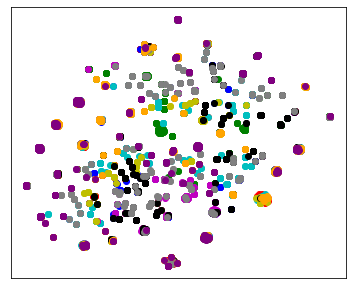

In [31]:
if state.vae.p.y_dim:
    _ = tsne_plot(f, r"$f \sim Q_{F|X=x_{obs}}$", legend=False, filename='tsne_f')

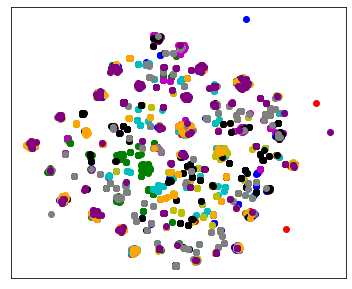

In [32]:
if state.vae.p.y_dim:
    _ = tsne_plot(marginal_f, r"$ \Pr(e_k \in F |X_{obs})$", legend=False, filename='tsne_mu')    

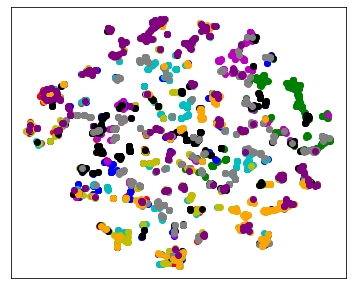

In [33]:
if state.vae.p.y_dim:
    _ = tsne_plot(scores, r"$ w_k \phi_k(f) |X=x_{obs}$", legend=False, filename='tsne_scores')    

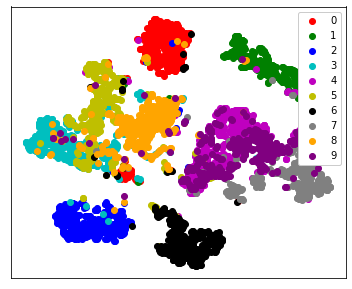

In [34]:
if state.vae.p.y_dim:
    #_ = tsne_plot(f, r"$F|X_{obs}$")
    #_ = tsne_plot(marginal_f, r"$\Pr(k|X_{obs})$")
    _ = tsne_plot(y, r"$y \sim Q_{Y|X=x_{obs}}$", legend=True, filename='tsne_y')

In [35]:
if state.vae.p.z_dim:
    _ = tsne_plot(z, r"$Z|X_{obs}$")

In [36]:
if state.vae.p.z_dim:
    _ = tsne_plot((z > 0.1) * 1.0, r"$Z > 0.1 | X_{obs}$")

In [37]:
if state.vae.p.z_dim:
    _ = tsne_plot((z > 0.01) * 1.0, r"$Z > 0.01 | X_{obs}$")

In [38]:
if state.vae.p.z_dim:
    _ = plt.hist((z > 0.).sum(-1).flatten(), label="0")
    _ = plt.hist((z > 0.01).sum(-1).flatten(), label="0.01")
    _ = plt.hist((z > 0.1).sum(-1).flatten(), label="0.1")
    _ = plt.hist((z > 0.5).sum(-1).flatten(), label="0.5")
    _ = plt.legend()

## Marginal samples per class

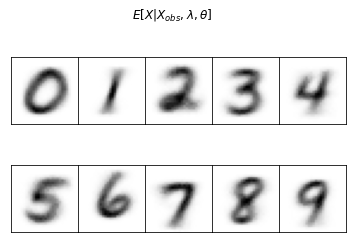

In [39]:
marginal_x = x.mean(1)
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(marginal_x[c].reshape(args.height, args.width), cmap='Greys')
    #axs[c // 5, c % 5].set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
_ = fig.suptitle(r'$E[X|X_{obs}, \lambda, \theta]$')    

In [40]:
#np.save(open('to-vlad2-f.npy', 'wb'), f)

In [41]:
#np.save(open('to-vlad2-marginal.npy', 'wb'), marginal_f)

In [42]:
#np.save(open('to-vlad2-y.npy', 'wb'), y)

In [43]:
#np.save(open('to-vlad2-scores.npy', 'wb'), scores)